### Code to Evaluate Model Performance and Classify Anomalies

Note: code uses datasets from manning_baselines.ipynb so ensure that is ran first

In [40]:
import pandas as pd
from joblib import load
import xarray as xr
from pathlib import Path
from datetime import datetime, timedelta

import sys
sys.path.append('../')
import setup

import matplotlib.pyplot as plt
import seaborn as sns

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [41]:
site = setup.site
site_name = setup.site_dict[site]
compound = setup.compound

print(f"Exploring {compound} at {site_name}.")

Exploring hfc-134a at Mace Head, Ireland.


#### Functions

In [42]:
def make_predictions():
    """
    Make predictions based on the previously trained model.

    Returns:
    - results (pandas.DataFrame): DataFrame containing the predicted flags, actual flags, and mf values.
    """

    # load in data from manning_baselines.ipynb
    data_balanced_df = pd.read_csv(data_path/'for_model.csv', index_col='time')
    data_balanced_ds = xr.open_dataset(data_path/'data_balanced_ds.nc')

    # making predictions based on model
    if "predicted_flag" in data_balanced_df.columns:
        data_balanced_df.drop(columns=["predicted_flag"], inplace=True)
    # Load model
    rf_model = load(data_path/'rf_model.joblib')
    # Predict baseline values
    df_predict = data_balanced_df.copy()
    df_predict.drop(columns=["flag"], inplace=True)
    class_probabilities_predict = rf_model.predict_proba(df_predict.reset_index(drop=True))
    threshold = setup.confidence_threshold
    y_pred = (class_probabilities_predict[:,1] >= threshold).astype(int)

    data_balanced_df["predicted_flag"] = y_pred

    columns_to_keep = ["flag", "predicted_flag"]
    results = data_balanced_df[columns_to_keep].copy()
    results["mf"] = data_balanced_ds.mf.values

    return results

In [43]:
def calc_statistics(results):
    """
    Calculates statistics to compare model to Manning's flags.

    Args:
    - results (pandas.DataFrame): Dataframe containing the predicted flags, Manning's flags, and mf values.

    Returns:
    - None
    """

    actual_values = results["mf"].where((results["flag"] == 1)).dropna()
    predicted_values = results["mf"].where(results["predicted_flag"] == 1).dropna()

    actual_mean = actual_values.mean()
    predicted_mean = predicted_values.mean()

    actual_std = actual_values.std()
    predicted_std = predicted_values.std()

    num_baseline = results["predicted_flag"].where(results["predicted_flag"] == 1).count()
    num_not_baseline = results["predicted_flag"].where(results["predicted_flag"] == 0).count()

    print(f'Manning Mean: {actual_mean:.3f}, Model Mean: {predicted_mean:.3f}')
    print(f'Manning Std Dev: {actual_std:.3f}, Model Std Dev: {predicted_std:.3f}')
    print(f'Number of predicted baseline values: {num_baseline}, Number of predicted non-baseline values: {num_not_baseline}')

In [44]:
import matplotlib.dates as mdates

In [45]:
def plot_predictions(results):
    """
    Plots mole fraction against time, with the predicted baselines and Manning's baselines highlighted.

    Args:
    - results (pandas.DataFrame): Dataframe containing the predicted flags, Manning's flags, and mf values.
    
    Returns:
    - None
    """

    fig, ax = plt.subplots(figsize=(20,8))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")

    results["mf"].plot(ax=ax, label="All Data", alpha=0.4)
    results["mf"].where(results["predicted_flag"] == 1).plot(ax=ax, label="Predicted Baselines", color='red')
    results["mf"].where(results["flag"] == 1).plot(ax=ax, label="Baselines", color='green', alpha=0.75)

    plt.ylabel("mole fraction in air / ppt")
    plt.title(f"{compound} at {site_name}", fontsize=15)
    plt.legend(loc="lower right", fontsize=12)

In [46]:
def plot_predictions_monthly(results):
    """
    Plots the predicted baselines and their standard deviations against the Manning baselines and their standard deviations, highlighting any points outside three standard deviations.

    Args:
    - results (pandas.DataFrame): Dataframe containing the predicted flags, Manning's flags, and mf values.

    Returns:
    - None
    """    

    # extracting flags and predicted flags
    df_pred = results.where(results["predicted_flag"] == 1).dropna()
    df_actual = results.where(results["flag"] == 1).dropna()

    df_pred.index = pd.to_datetime(df_pred.index)
    df_actual.index = pd.to_datetime(df_actual.index)


    # resampling to monthly averages
    df_pred_monthly = df_pred.resample('M').mean()
    df_actual_monthly = df_actual.resample('M').mean()
    # setting index to year and month only
    df_pred_monthly.index = df_pred_monthly.index.to_period('M')
    df_actual_monthly.index = df_actual_monthly.index.to_period('M')

    # calculating standard deviation
    std_pred_monthly = df_pred.groupby(df_pred.index.to_period('M'))["mf"].std().reset_index()
    std_pred_monthly.set_index('time', inplace=True)
    std_actual_monthly = df_actual.groupby(df_actual.index.to_period('M'))["mf"].std().reset_index()
    std_actual_monthly.set_index('time', inplace=True)


    # plotting
    fig, ax = plt.subplots(figsize=(20,8))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")

    df_actual_monthly["mf"].plot(ax=ax, label="Baselines", color='green', alpha=0.75)
    df_pred_monthly["mf"].plot(ax=ax, label="Predicted Baselines", color='red')

    # adding standard deviation shading
    upper_actual = df_actual_monthly["mf"] + std_actual_monthly['mf']
    lower_actual = df_actual_monthly["mf"] - std_actual_monthly['mf']

    ax.fill_between(df_actual_monthly.index, lower_actual, upper_actual, color='green', alpha=0.2, label="Baseline Standard Deviation")

    upper_pred = df_pred_monthly["mf"] + std_pred_monthly['mf']
    lower_pred = df_pred_monthly["mf"] - std_pred_monthly['mf']
    ax.fill_between(df_pred_monthly.index, lower_pred, upper_pred, color='red', alpha=0.2, label="Predicted Baseline Standard Deviation")


    # adding tolerance range based on 3 standard deviations
    upper_range = df_actual_monthly["mf"] + 3*(std_actual_monthly['mf'])
    lower_range = df_actual_monthly["mf"] - 3*(std_actual_monthly['mf'])


    # calculating overall standard deviation for arrows
    overall_std = df_actual_monthly["mf"].std()

    # adding labels to points outside tolerance range
    '''
    for i in range(len(df_actual_monthly)):
        if df_pred_monthly["mf"].iloc[i] >= upper_range.iloc[i]:
            arrow_end = df_pred_monthly["mf"].iloc[i] + (0.5*overall_std)
            ax.annotate(df_pred_monthly.index[i].strftime('%B %Y'), 
                        xy=(df_pred_monthly.index[i], df_pred_monthly["mf"].iloc[i]), 
                        xytext=(df_pred_monthly.index[i], arrow_end), 
                        arrowprops=dict(facecolor='black', shrink=0.05),
                        horizontalalignment='center', verticalalignment='bottom')
        
        elif df_pred_monthly["mf"].iloc[i] <= lower_range.iloc[i]:
            arrow_end = df_pred_monthly["mf"].iloc[i] - (0.5*overall_std)
            ax.annotate(df_pred_monthly.index[i].strftime('%B %Y'), 
                        xy=(df_pred_monthly.index[i], df_pred_monthly["mf"].iloc[i]), 
                        xytext=(df_pred_monthly.index[i], arrow_end), 
                        arrowprops=dict(facecolor='black', shrink=0.05),
                        horizontalalignment='center', verticalalignment='bottom')
    '''
    for idx, row in df_pred_monthly.iterrows():
        if row["mf"] >= upper_range.loc[idx]:
            arrow_end = row["mf"] + (overall_std * 0.5)
            ax.annotate(idx.strftime('%B %Y'),
                        xy=(idx, row["mf"]),
                        xytext=(idx, arrow_end),
                        arrowprops=dict(facecolor='black', shrink=0.05),
                        horizontalalignment='center', verticalalignment='bottom')
        
        if row["mf"] <= lower_range.loc[idx]:
            arrow_end = row["mf"] - (overall_std * 0.5)
            ax.annotate(idx.strftime('%B %Y'),
                        xy=(idx, row["mf"]),
                        xytext=(idx, arrow_end),
                        arrowprops=dict(facecolor='black', shrink=0.05),
                        horizontalalignment='center', verticalalignment='bottom')

            
    plt.ylabel("mole fraction in air / ppt")
    plt.title(f"{compound} at {site_name}", fontsize=15)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

In [47]:
def analyse_anomalies(results, anomalies_list):
    """
    Plots a given set of anomalous months, comparing the predicted baselines to the Manning baselines.
    Works when considering two or more anomalous months.

    Args:
    - results (pandas.DataFrame): Dataframe containing the predicted flags, Manning's flags, and mf values.
    - anomalies_list (list): A list of strings representing the anomalous months in the format 'YYYY-MM'.

    Returns:
    - None
    """    
    def get_days(month):
        """
        Returns the start and end dates of a given month. Only used for plotting anomalies.

        Args:
        - month (str): A string representing the month in the format 'YYYY-MM'.

        Returns:
        - tuple: A tuple containing the start date and end date of the month in the format 'YYYY-MM-DD'.
        """
        start_date = datetime.strptime(month, "%Y-%m")
        end_date = (start_date + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')
    

    # getting start and end dates for each anomalous month
    anomalies_range_list = [day for month in anomalies_list for day in get_days(month)]

    # plotting
    figsize_list = [8, 10, 18, 25, 30, 40, 50, 60, 70, 80, 90, 100]

    fig, axs = plt.subplots(len(anomalies_list), 2, 
                            figsize=(20,figsize_list[len(anomalies_list)-1]))
    sns.set(style='darkgrid')
    sns.set_palette("colorblind")

    for n in range(0, len(anomalies_list)):
        start, end = anomalies_range_list[2*n], anomalies_range_list[2*n+1]
        month = results.loc[start:end]
        month.index = pd.to_datetime(month.index)
        # calculating some stats
        pred_mean = month["mf"].where(month["predicted_flag"] == 1).mean()
        actual_mean = month["mf"].where(month["flag"] == 1).mean()
        pred_count = month["mf"].where(month["predicted_flag"] == 1).count()
        actual_count = month["mf"].where(month["flag"] == 1).count()

        # plotting baseline points
        axs[n,0].scatter(month.index, month["mf"].where(month["flag"] == 1), 
                       color='green', label=f"Baselines (count={actual_count})", marker='x', s=75)
        axs[n,0].scatter(month.index, month["mf"].where(month["predicted_flag"] == 1), 
                       color='red', label=f"Predicted Baselines (count={pred_count})", marker='x', s=75)
        # plotting mean lines
        axs[n,0].axhline(y=actual_mean, color='green', linestyle='-', label='Actual Mean')
        axs[n,0].axhline(y=pred_mean, color='red', linestyle='--', label='Predicted Mean') 

        # adding tolerance limit line
        actual_std = month["mf"].where(month["flag"] == 1).std()
        tolerance_limit = actual_mean + (3*actual_std)
        axs[n,0].axhline(y=tolerance_limit, color='blue', linestyle='-', label='Tolerance Limit', alpha=0.5)

        # formatting plot
        start_date = datetime.strptime(start, '%Y-%m-%d')
        formatted_date = start_date.strftime('%b %Y')
        axs[n,0].set_title(f"{formatted_date}", fontsize=20)

    
        axs[n,0].set_ylabel("mole fraction in air / ppt")
        axs[n,0].legend(fontsize=14)
        
        # comparing counts
        counts = []
        true_positive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 1)).count()
        false_postive_count = month["mf"].where((month["predicted_flag"] == 1) & (month["flag"] == 0)).count()
        true_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 0)).count()
        false_negative_count = month["mf"].where((month["predicted_flag"] == 0) & (month["flag"] == 1)).count()
        counts.append(true_positive_count)
        counts.append(false_postive_count)
        counts.append(true_negative_count)
        counts.append(false_negative_count)

        axs[n,1].bar(["True Positive", "False Positive", "True Negative", "False Negative"], counts, color='grey')

        for i in range(len(counts)):
            percentage = counts[i] / month["mf"].count() * 100
            axs[n,1].text(i, counts[i], f"{counts[i]} ({percentage:.1f}%)", fontsize=10, ha='center', va='bottom')


    fig.suptitle(f"Anomalous Months for {compound} at {site_name}", fontsize=25)
    fig.set_tight_layout(True)
    plt.show()

#### Results

Manning Mean: 71.668, Model Mean: 73.349
Manning Std Dev: 34.123, Model Std Dev: 33.385
Number of predicted baseline values: 3617, Number of predicted non-baseline values: 22810


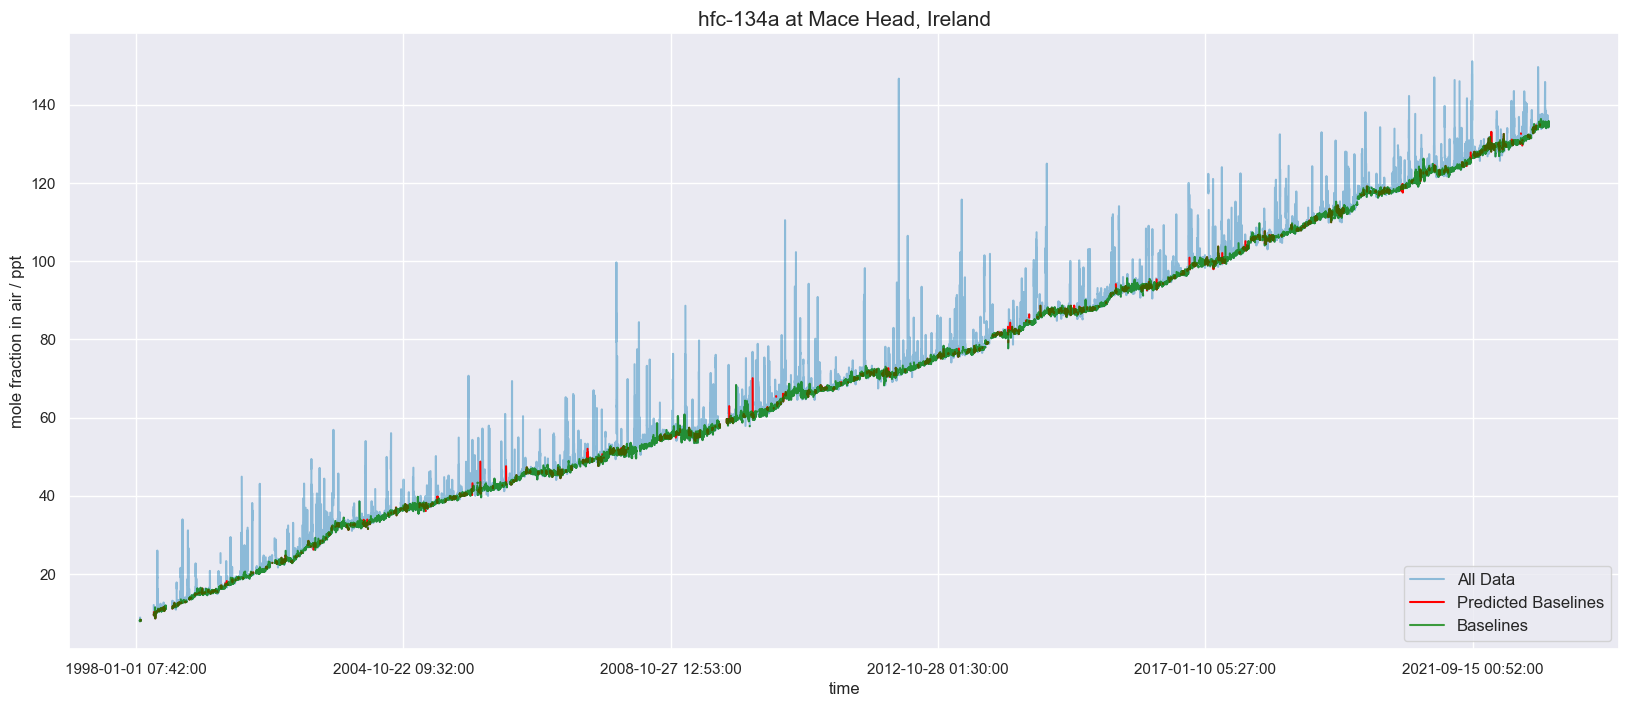

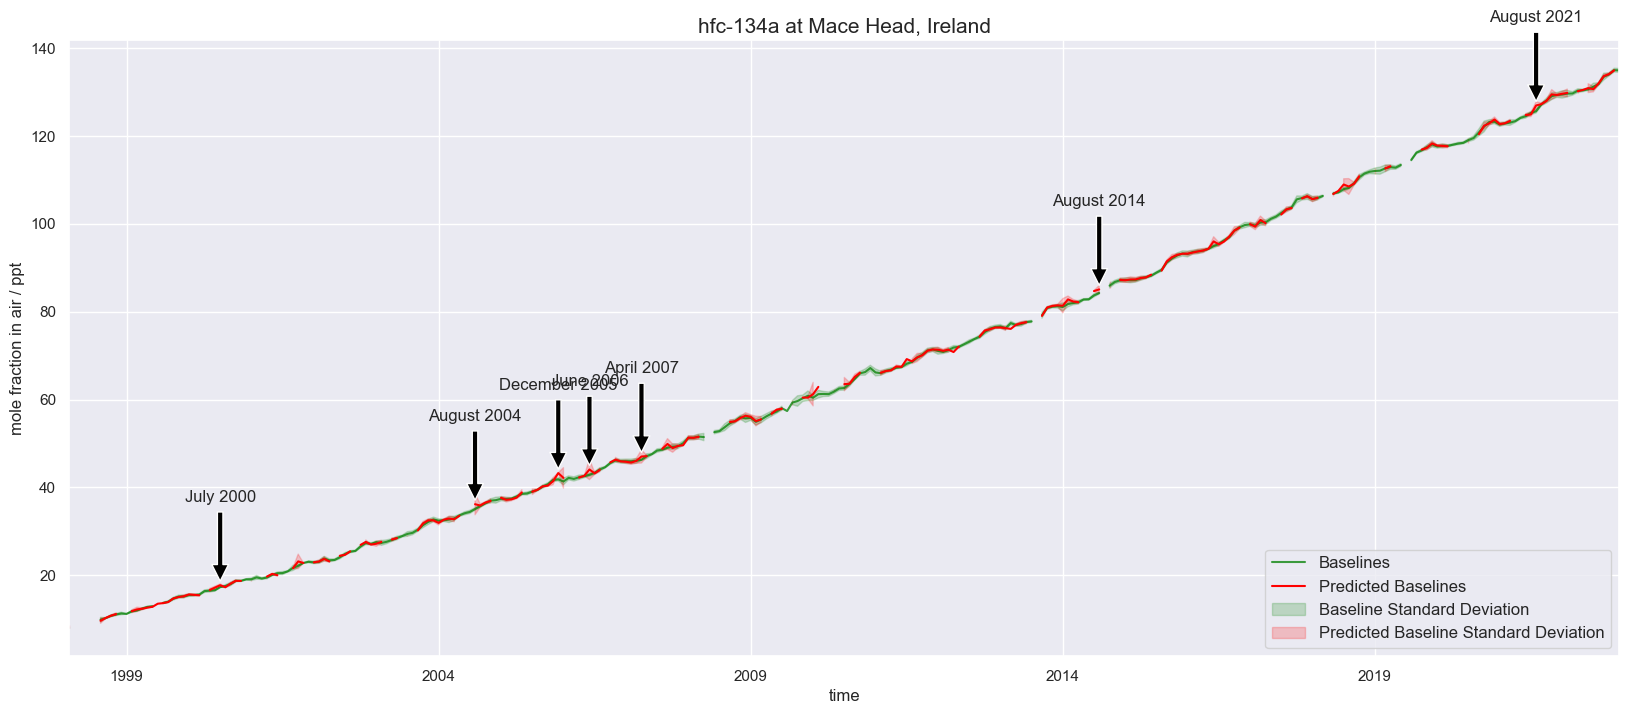

In [48]:
results = make_predictions()
calc_statistics(results)
plot_predictions(results)
plot_predictions_monthly(results)

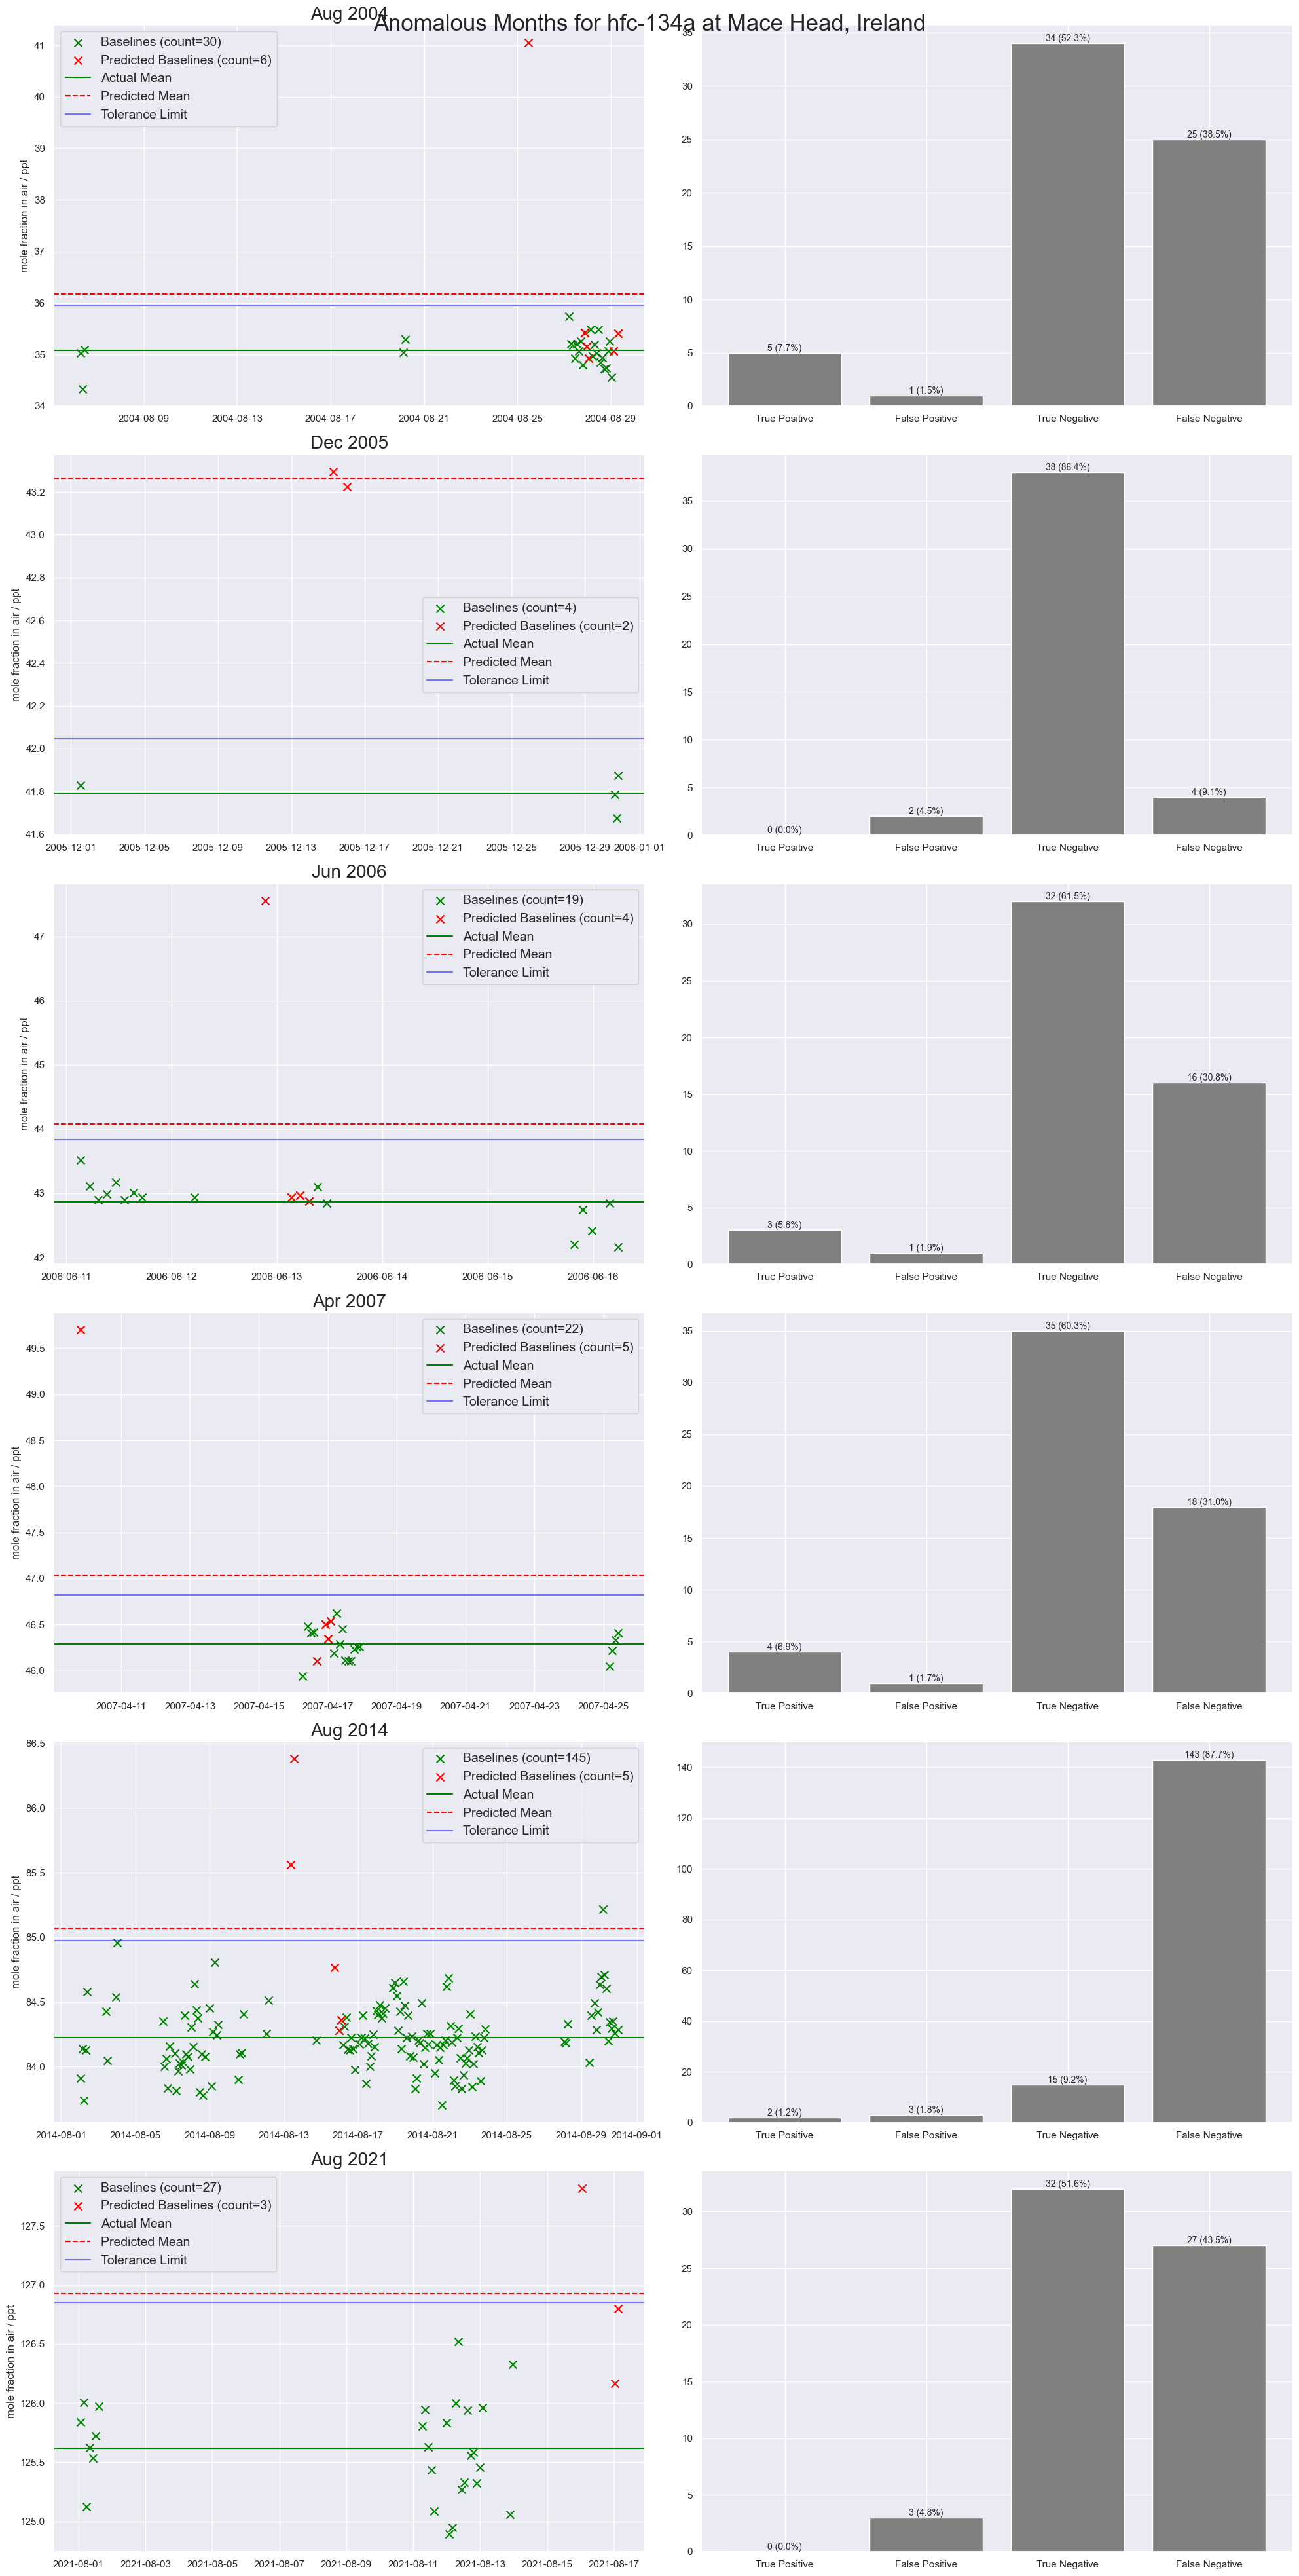

In [49]:
anomalies_list = ['2004-08', '2005-12', '2006-06', '2007-04', '2014-08', '2021-08']
analyse_anomalies(results, anomalies_list)